In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

#README  https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
num_digits = 5
num_labels = 11
num_image_packs = 3
num_channels = 1

tmp_dataset, tmp_labels = None, None
for i in np.random.choice(range(9), num_image_packs):
    pickle_file = 'SVHN_extra_%d.pickle' % i
    
    with open(pickle_file, 'rb') as f:
        tmp_save = pickle.load(f)
    
    tmp_d = tmp_save['dataset']
    tmp_l = tmp_save['labels']
    
    if tmp_dataset is None:
        tmp_dataset = tmp_d
    else:
        tmp_dataset = np.append(tmp_dataset, tmp_d, 0)
        
    if tmp_labels is None:
        tmp_labels = tmp_l
    else:
        tmp_labels = np.append(tmp_labels, tmp_l, 0)


keep = [i for i, label in enumerate(tmp_labels) if len(label) <= num_digits]
tmp_dataset = tmp_dataset[keep]
tmp_labels = tmp_labels[keep]



def reformat_labels(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    return dataset_output, labels_output

tmp_dataset, tmp_labels = reformat_labels(tmp_dataset, tmp_labels)




def shuffle(dataset, labels):
    indexes = np.arange(labels.shape[0])
    np.random.shuffle(indexes)
    return dataset[indexes], labels[indexes]

tmp_dataset, tmp_labels = shuffle(tmp_dataset, tmp_labels)
    


def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    if len(img.shape) > 2:
        plt.imshow(np.reshape(img, img.shape[:2]))
    else:
        plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])

    

train_valid_test_split = [int(tmp_labels.shape[0] * a) for a in [0.7, 0.05, 0.3]]

train_dataset = tmp_dataset[0:train_valid_test_split[0]]
train_labels = tmp_labels[0:train_valid_test_split[0]]

valid_dataset = tmp_dataset[train_valid_test_split[0]:np.sum(train_valid_test_split[:2])]
valid_labels = tmp_labels[train_valid_test_split[0]:np.sum(train_valid_test_split[:2])]

test_dataset = tmp_dataset[np.sum(train_valid_test_split[:2]):]
test_labels = tmp_labels[np.sum(train_valid_test_split[:2]):]

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (42000, 45, 80, 1) (42000, 5, 11)
Validation set (3000, 45, 80, 1) (3000, 5, 11)
Test set (15000, 45, 80, 1) (15000, 5, 11)


In [4]:
# Clean up after ourselves
%reset_selective -f tmp_.*

Labels [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (45, 80, 1)
Color range -0.5 0.5


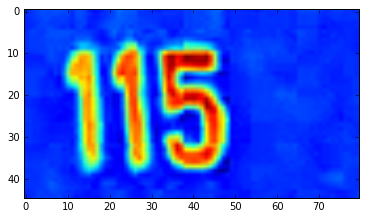

Labels [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (45, 80, 1)
Color range -0.5 0.5


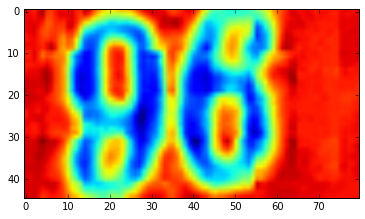

Labels [[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
Dtype float32
Shape (45, 80, 1)
Color range -0.5 0.5


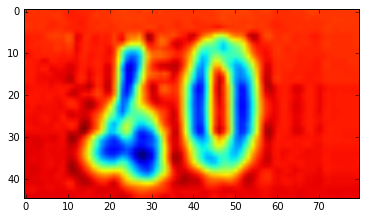

In [5]:
for i in np.random.choice(range(train_labels.shape[0]), 3):
    show_image(train_dataset[i], train_labels[i])

In [ ]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_list(predictions, labels):
    result = np.mean([accuracy(predictions[i],
                               labels[:, i, :])
                        for i in range(num_digits)])
    return result

def run_graph(graph):
    save_steps = 10000
    eval_steps = 1000
    valid_steps = 1000

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver()
        print('Initialized')
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]


            feed_dict = {tf_train_labels[i] : batch_labels[:, i, :] for i in range(num_digits)}
            feed_dict[tf_train_dataset] = batch_data        


            fetches = [optimizer, loss]
            results = session.run(fetches, feed_dict=feed_dict)


            if (step % eval_steps == 0):
                print('Learning rate:', learning_rate.eval())
                print('Minibatch loss at step %d: %f' % (step, results[1]))

                fetches = train_prediction
                results = session.run(fetches, feed_dict={tf_train_dataset : batch_data})
                train_accuracy = accuracy_list(
                    results,
                    batch_labels)

                print('Minibatch accuracy: %.1f%%' % train_accuracy)

            if step > 0:
                if (step % valid_steps == 0):
                    valid_accuracy = accuracy_list(
                        [valid_prediction[i].eval() for i in range(num_digits)],
                        valid_labels)
                    print('Validation accuracy: %.1f%%' % valid_accuracy)

                if step % save_steps == 0:
                    #print("Saving")
                    #save_path = saver.save(session, "saves/model%d.ckpt" % step)

                    test_accuracy = accuracy_list(
                        [test_prediction[i].eval() for i in range(num_digits)],
                        test_labels)
                    print('Test accuracy: %.1f%%' % test_accuracy)

    print("Finished")

In [ ]:
#Add droupout everywhere
num_steps = 100001
batch_size = 32

patch_size = 5
depth = 16
depth2 = 32

# Taken from tensorflow tutorial
num_hidden = 256

graph = tf.Graph()
stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([60 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)
            
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        if dropout: hidden = tf.nn.dropout(hidden, 0.75)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        if dropout: hidden = tf.nn.dropout(hidden, 0.75)
            
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)        
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
        
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph)

45 80
Initialized
Learning rate:

In [ ]:
# Change stride
num_steps = 100001
batch_size = 32

patch_size = 5
depth = 16
depth2 = 32

# Taken from tensorflow tutorial
num_hidden = 256

graph = tf.Graph()
stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([240 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)
            
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        if dropout: hidden = tf.nn.dropout(hidden, 0.75)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        if dropout: hidden = tf.nn.dropout(hidden, 0.75)
            
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)        
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph)

In [ ]:
# Adagrad
num_steps = 100001
batch_size = 32

patch_size = 5
depth = 16
depth2 = 32

# Taken from tensorflow tutorial
num_hidden = 256

graph = tf.Graph()
stddev = 0.1

img_height, img_width = test_dataset[0].shape[:2]
print(img_height, img_width)

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    depth,
                                                    depth2], stddev=stddev), name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[depth2]), name="layer2_biases")

    layer3_weights = tf.Variable(tf.truncated_normal([240 * depth2, num_hidden], stddev=stddev), name="layer3_weights")

    layer3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer3_biases")

    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)
            
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        if dropout: hidden = tf.nn.dropout(hidden, 0.75)
        
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        if dropout: hidden = tf.nn.dropout(hidden, 0.75)
            
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)        
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.add_n([tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        ))for i in range(num_digits)])
                       
    
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, num_steps, 0.596)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph)